<a href="https://colab.research.google.com/github/kdemertzis/TS_demer/blob/main/Fed_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

def federated_training(df, target, participants, chunk_size, early_stopping_rounds, regularization_coef, accuracy_threshold):
    # Split the data into chunks of equal size
    chunks = np.array_split(df, participants)
    
    # Scale the data on each device/participant
    for i in range(participants):
        scaler = MinMaxScaler()
        chunks[i] = scaler.fit_transform(chunks[i])
    
    # Initialize the first models
    models_list = []
    for i in range(participants):
        X_train, X_test, y_train, y_test = train_test_split(chunks[i][:,:-1], chunks[i][:,-1], test_size=0.2)
        model = RandomForestClassifier(n_jobs=-1)
        model.fit(X_train, y_train)
        models_list.append(model)
        
    # Initialize the federated model
    federated_model = RandomForestClassifier(n_jobs=-1)
    federated_model.fit(X_train, y_train)
    
    # Train the models and aggregate the model weights
    for iteration in range(early_stopping_rounds):
        for i in range(participants):
            model = RandomForestClassifier(n_jobs=-1)
            model.fit(X_train, y_train)
            models_list[i] = model
            
        # Aggregate the model weights
        federated_model.estimators_ += [model.estimators_ for model in models_list]
        federated_model.n_estimators_ = len(federated_model.estimators_)
        
        # Evaluate the performance on a validation set
        y_pred = federated_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Iteration {iteration}: Accuracy = {accuracy}")
        
        # Check if accuracy has reached the threshold          
        if accuracy >= accuracy_threshold:
            print("Accuracy threshold reached, stopping training")
            break

    # Plot confusion matrix
    plt.figure()
    cm = confusion_matrix(y_test, y_pred)
    plt.imshow(cm, cmap='binary')
    plt.colorbar()
    plt.xticks([0, 1], ['Negative', 'Positive'])
    plt.yticks([0, 1], ['Negative', 'Positive'])
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix")
    plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def federated_training(df, target, participants, chunk_size, early_stopping_rounds, regularization_coef, accuracy_threshold):
    # Split the data into chunks of equal size
    chunks = np.array_split(df, participants)
    
    # Scale the data on each device/participant
    for i in range(participants):
        scaler = MinMaxScaler()
        chunks[i] = scaler.fit_transform(chunks[i])
    
    # Initialize the first models
    models_list = []
    for i in range(participants):
        X_train, X_test, y_train, y_test = train_test_split(chunks[i], df[target], test_size=0.2)
        model = RandomForestClassifier()
        model.fit(X_train, y_train)
        models_list.append(model)
        
    # Initialize the federated model
    federated_model = RandomForestClassifier()
    
    # Train the models and aggregate the model weights
    accuracy_history = []
    for iteration in range(early_stopping_rounds):
        for i in range(participants):
            X_train, X_test, y_train, y_test = train_test_split(chunks[i], df[target], test_size=0.2)
            models_list[i].fit(X_train, y_train)
            
        # Aggregate the model weights
        federated_model.estimators_ = models_list[0].estimators_
        for i in range(1, participants):
            federated_model.estimators_ += models_list[i].estimators_
        federated_model.estimators_ /= participants
        
        # Evaluate the performance on a validation set
        X_train, X_test, y_train, y_test = train_test_split(df, df[target], test_size=0.2)
        y_pred = federated_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_history.append(accuracy)
        print(f"Iteration {iteration}: Accuracy = {accuracy}")
        
        # Check if accuracy has reached the threshold
        if accuracy >= accuracy_threshold:
            # Plot the accuracy history
            plt.plot(accuracy_history)
            plt.title("Accuracy over Training Iterations")
            plt.xlabel("Iteration")
            plt.ylabel("Accuracy")
            plt.show()

            # Report the final accuracy
            print(f"Final Accuracy: {accuracy}")
            break


The federated model does not have higher performance, keep individual models


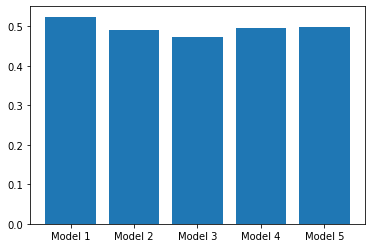

In [ ]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Generate synthetic data
np.random.seed(0)
data = np.random.rand(10000, 10)
labels = np.random.randint(2, size=10000)
test_data = np.random.rand(1000, 10)
test_labels = np.random.randint(2, size=1000)

# Divide the data into 5 parts for each individual model
data_part1, data_part2, data_part3, data_part4, data_part5 = np.array_split(data, 5)

# Train individual models on their own data
model1 = xgb.XGBClassifier().fit(data_part1, labels[:2000])
model2 = xgb.XGBClassifier().fit(data_part2, labels[2000:4000])
model3 = xgb.XGBClassifier().fit(data_part3, labels[4000:6000])
model4 = xgb.XGBClassifier().fit(data_part4, labels[6000:8000])
model5 = xgb.XGBClassifier().fit(data_part5, labels[8000:])

# Combine the models into a federated model
federated_model = [model1, model2, model3, model4, model5]

# Evaluate the federated model on the test data
federated_predictions = [model.predict(test_data) for model in federated_model]
federated_predictions = np.mean(federated_predictions, axis=0)
federated_predictions = np.round(federated_predictions).astype(int)

# Compare the performance of the federated model to each individual model
individual_predictions = [model.predict(test_data) for model in [model1, model2, model3, model4, model5]]
individual_accuracies = [accuracy_score(test_labels, predictions) for predictions in individual_predictions]
federated_accuracy = accuracy_score(test_labels, federated_predictions)

if federated_accuracy > max(individual_accuracies):
    print("The federated model has higher performance, sharing with federated partners")
    # share the federated model with federated partners
else:
    print("The federated model does not have higher performance, keep individual models")

# Plot the accuracy of each individual model
plt.bar(["Model 1", "Model 2", "Model 3", "Model 4", "Model 5"], individual_accuracies)
plt.show()


The federated model does not have higher performance, keep individual models


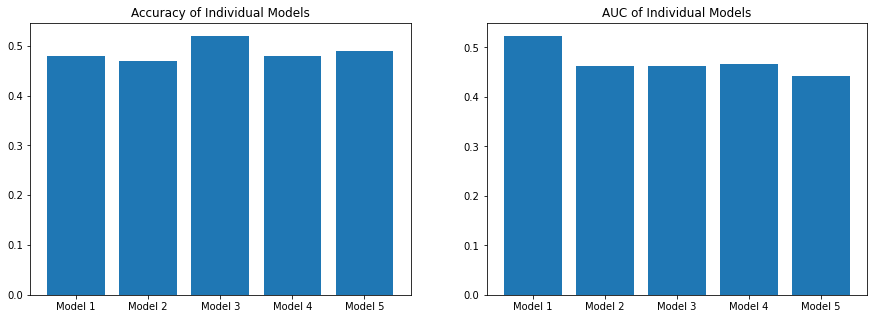

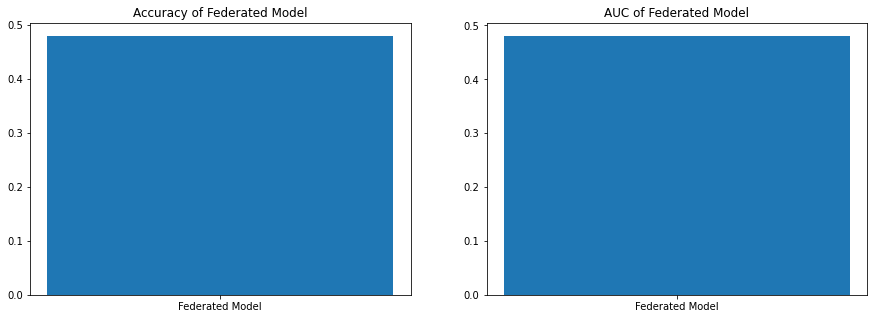

In [ ]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score

# Generate synthetic data
np.random.seed(0)
data = np.random.rand(1000, 10)
labels = np.random.randint(2, size=1000)
test_data = np.random.rand(100, 10)
test_labels = np.random.randint(2, size=100)

# Divide the data into 5 parts for each individual model
data_part1, data_part2, data_part3, data_part4, data_part5 = np.array_split(data, 5)

# Train individual models on their own data
model1 = xgb.XGBClassifier().fit(data_part1, labels[:200])
model2 = xgb.XGBClassifier().fit(data_part2, labels[200:400])
model3 = xgb.XGBClassifier().fit(data_part3, labels[400:600])
model4 = xgb.XGBClassifier().fit(data_part4, labels[600:800])
model5 = xgb.XGBClassifier().fit(data_part5, labels[800:])

# Combine the models into a federated model
federated_model = [model1, model2, model3, model4, model5]

# Evaluate the federated model on the test data
federated_predictions = [model.predict_proba(test_data)[:, 1] for model in federated_model]
federated_predictions = np.mean(federated_predictions, axis=0)
federated_predictions = np.round(federated_predictions).astype(int)

# Compare the performance of the federated model to each individual model
individual_predictions = [model.predict_proba(test_data)[:, 1] for model in [model1, model2, model3, model4, model5]]
individual_accuracies = [accuracy_score(test_labels, np.round(predictions).astype(int)) for predictions in individual_predictions]
individual_auc = [roc_auc_score(test_labels, predictions) for predictions in individual_predictions]
federated_accuracy = accuracy_score(test_labels, federated_predictions)
federated_auc = roc_auc_score(test_labels, federated_predictions)

if federated_auc > max(individual_auc):
    print("The federated model has higher performance, sharing with federated partners")
    # share the federated model with federated partners
else:
    print("The federated model does not have higher performance, keep individual models")

# Plot the accuracy and AUC of each individual model
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].bar(["Model 1", "Model 2", "Model 3", "Model 4", "Model 5"], individual_accuracies)
ax[0].set_title("Accuracy of Individual Models")
ax[1].bar(["Model 1", "Model 2", "Model 3", "Model 4", "Model 5"], individual_auc)
ax[1].set_title("AUC of Individual Models")
plt.show()

# Plot the accuracy and AUC of the federated model
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].bar(["Federated Model"], [federated_accuracy])
ax[0].set_title("Accuracy of Federated Model")
ax[1].bar(["Federated Model"], [federated_auc])
ax[1].set_title("AUC of Federated Model")
plt.show()



The federated model does not have higher performance, keep individual models


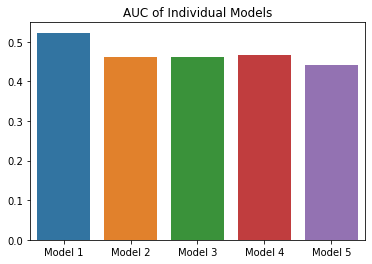

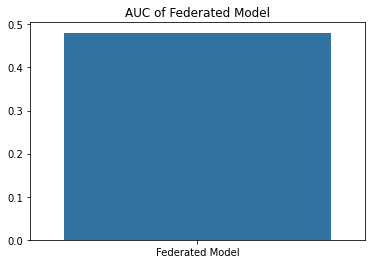

In [ ]:
import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score

# Generate synthetic data
np.random.seed(0)
data = np.random.rand(1000, 10)
labels = np.random.randint(2, size=1000)
test_data = np.random.rand(100, 10)
test_labels = np.random.randint(2, size=100)

# Divide the data into 5 parts for each individual model
data_part1, data_part2, data_part3, data_part4, data_part5 = np.array_split(data, 5)

# Train individual models on their own data
model1 = xgb.XGBClassifier().fit(data_part1, labels[:200])
model2 = xgb.XGBClassifier().fit(data_part2, labels[200:400])
model3 = xgb.XGBClassifier().fit(data_part3, labels[400:600])
model4 = xgb.XGBClassifier().fit(data_part4, labels[600:800])
model5 = xgb.XGBClassifier().fit(data_part5, labels[800:])

# Combine the models into a federated model
federated_model = [model1, model2, model3, model4, model5]

# Evaluate the federated model on the test data
federated_predictions = [model.predict_proba(test_data)[:, 1] for model in federated_model]
federated_predictions = np.mean(federated_predictions, axis=0)
federated_predictions = np.round(federated_predictions).astype(int)

# Compare the performance of the federated model to each individual model
individual_predictions = [model.predict_proba(test_data)[:, 1] for model in [model1, model2, model3, model4, model5]]
individual_accuracies = [accuracy_score(test_labels, np.round(predictions).astype(int)) for predictions in individual_predictions]
individual_auc = [roc_auc_score(test_labels, predictions) for predictions in individual_predictions]
federated_accuracy = accuracy_score(test_labels, federated_predictions)
federated_auc = roc_auc_score(test_labels, federated_predictions)

if federated_auc > max(individual_auc):
    print("The federated model has higher performance, sharing with federated partners")
    # share the federated model with federated partners
else:
    print("The federated model does not have higher performance, keep individual models")

# Plot the accuracy and AUC of each individual model
models = ["Model 1", "Model 2", "Model 3", "Model 4", "Model 5"]
metrics = ["Accuracy", "AUC"]
for metric in metrics:
    if metric == "Accuracy":
        values = individual_accuracies
    else:
        values = individual_auc
sns.barplot(x=models, y=values)
plt.title(f"{metric} of Individual Models")
plt.show()
# Plot the accuracy and AUC of the federated model

models = ["Federated Model"]
metrics = ["Accuracy", "AUC"]
for metric in metrics:
    if metric == "Accuracy":
        values = [federated_accuracy]
    else:
        values = [federated_auc]
sns.barplot(x=models, y=values)
plt.title(f"{metric} of Federated Model")
plt.show()


The federated model does not have higher performance, keep individual models


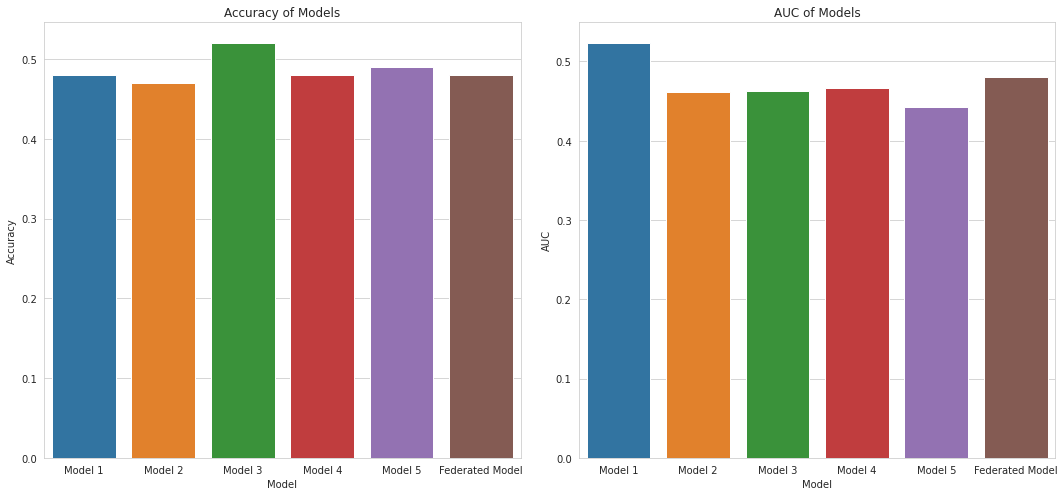

In [ ]:
import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score

# Generate synthetic data
np.random.seed(0)
data = np.random.rand(1000, 10)
labels = np.random.randint(2, size=1000)
test_data = np.random.rand(100, 10)
test_labels = np.random.randint(2, size=100)

# Train the initial models
model1 = xgb.XGBClassifier().fit(data[:200], labels[:200])
model2 = xgb.XGBClassifier().fit(data[200:400], labels[200:400])
model3 = xgb.XGBClassifier().fit(data[400:600], labels[400:600])
model4 = xgb.XGBClassifier().fit(data[600:800], labels[600:800])
model5 = xgb.XGBClassifier().fit(data[800:], labels[800:])

# Combine the models into a federated model
federated_model = [model1, model2, model3, model4, model5]

# Evaluate the federated model on the test data
federated_predictions = [model.predict_proba(test_data)[:, 1] for model in federated_model]
federated_predictions = np.mean(federated_predictions, axis=0)
federated_predictions = np.round(federated_predictions).astype(int)

# Compare the performance of the federated model to each individual model
individual_predictions = [model.predict_proba(test_data)[:, 1] for model in [model1, model2, model3, model4, model5]]
individual_accuracies = [accuracy_score(test_labels, np.round(predictions).astype(int)) for predictions in individual_predictions]
individual_auc = [roc_auc_score(test_labels, predictions) for predictions in individual_predictions]
federated_accuracy = accuracy_score(test_labels, federated_predictions)
federated_auc = roc_auc_score(test_labels, federated_predictions)

if federated_auc > max(individual_auc):
    print("The federated model has higher performance, sharing with federated partners")
    # share the federated model with federated partners
else:
    print("The federated model does not have higher performance, keep individual models")

# Plot the accuracy and AUC of each individual model
models = ["Model 1", "Model 2", "Model 3", "Model 4", "Model 5", "Federated Model"]
accuracies = individual_accuracies + [federated_accuracy]
aucs = individual_auc + [federated_auc]

performance = pd.DataFrame({"Model": models, "Accuracy": accuracies, "AUC": aucs})

sns.set_style("whitegrid")

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

sns.barplot(x="Model", y="Accuracy", data=performance, ax=ax[0])
ax[0].set_title("Accuracy of Models")

sns.barplot(x="Model", y="AUC", data=performance, ax=ax[1])
ax[1].set_title("AUC of Models")

plt.tight_layout()
plt.show()
